In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import seaborn as sns
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import yfinance as yf
%matplotlib inline

In [41]:
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
yf.pdr_override()

# For time stamps
from datetime import datetime


# The tech stocks we'll use for this analysis
company_ticker = ['TSLA']
company_name = ['TESLA']


end = datetime(2022,9,30)
start = datetime(end.year - 1, 9, 29)
company = {}
i = 0
for stock in company_ticker:
    company[stock] = yf.download(stock, start, end)
    company[stock]['company_name'] = company_name[i]
    company[stock]["Date"] = company[stock]["Close"].index
    i +=1

company = pd.concat(company.values(), axis=0)


[*********************100%***********************]  1 of 1 completed


In [42]:
# SAVE STOCK DATA
company.to_csv('TSLA.csv', index=False)

# LOAD STOCK DATA

Stock = pd.read_csv('./TSLA.csv')

df = Stock
df= df.rename(columns={'Close(t)':'Close'})
df.tail()

,Open,High,Low,Close,Adj Close,Volume,company_name,Date
248,283.089996,284.500000,272.820007,275.329987,275.329987,63748400,TESLA,2022-09-23
249,271.829987,284.089996,270.309998,276.010010,276.010010,58076900,TESLA,2022-09-26
250,283.839996,288.670013,277.510010,282.940002,282.940002,61925200,TESLA,2022-09-27
251,283.079987,289.000000,277.570007,287.809998,287.809998,54664800,TESLA,2022-09-28
252,282.760010,283.649994,265.779999,268.209991,268.209991,77620600,TESLA,2022-09-29


In [43]:
tweet_sent_df = pd.read_csv('tesla_sentiment.csv')

def changeDate(date_str):
    return datetime.strptime(date_str, '%m/%d/%y').strftime('%Y-%m-%d')
    
tweet_sent_df["Date"] = tweet_sent_df["Date"].apply(changeDate)
tweet_sent_df["Date"] = tweet_sent_df["Date"].isin(df['Date'])
tweet_sent_df = tweet_sent_df.drop(columns=["Date","Stock Name"])

df['High'] = df['High'].astype(float)
df['Low'] = df['Low'].astype(float)
df['Close'] = df['Close'].astype(float)
df['Adj Close'] = df['Adj Close'].astype(float)
df['Volume'] = df['Volume'].astype(float)
df['Open'] = df['Open'].astype(float)
df["positive"] = tweet_sent_df["positive"]
df["negative"] = tweet_sent_df["negative"]
df["compound"] = tweet_sent_df["compound"]

In [44]:

df.set_index('Date', inplace=True)
df.tail(30)

,Open,High,Low,Close,Adj Close,Volume,company_name,positive,negative,compound
Date,,,,,,,,,,
2022-08-18,306.000000,306.500000,301.853333,302.869995,302.869995,47500500.0,TESLA,0.104,0.778,0.9913
2022-08-19,299.000000,300.359985,292.500000,296.666656,296.666656,61395300.0,TESLA,0.080,0.797,0.9996
2022-08-22,291.913330,292.399994,286.296661,289.913330,289.913330,55843200.0,TESLA,0.067,0.812,0.9995
2022-08-23,291.453339,298.826660,287.923340,296.453339,296.453339,63984900.0,TESLA,0.084,0.780,0.9987
2022-08-24,297.563324,303.646667,296.500000,297.096680,297.096680,57259800.0,TESLA,0.062,0.850,0.9941
2022-08-25,302.359985,302.959991,291.600006,296.070007,296.070007,53230000.0,TESLA,0.083,0.820,0.9944
2022-08-26,297.429993,302.000000,287.470001,288.089996,288.089996,57163900.0,TESLA,0.091,0.794,0.9961
2022-08-29,282.829987,287.739990,280.700012,284.820007,284.820007,41864700.0,TESLA,0.092,0.803,0.9935
2022-08-30,287.869995,288.480011,272.649994,277.700012,277.700012,50541800.0,TESLA,0.089,0.805,0.9968


Closing Price

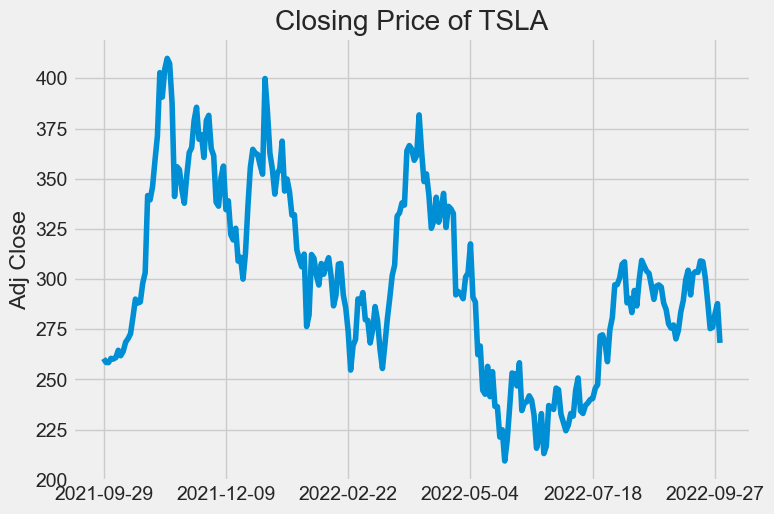

In [45]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)
for i, company in enumerate(company_ticker, 1):
    plt.subplot(2, 2, i)
    df['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {company_ticker[i - 1]}")
    
plt.tight_layout()

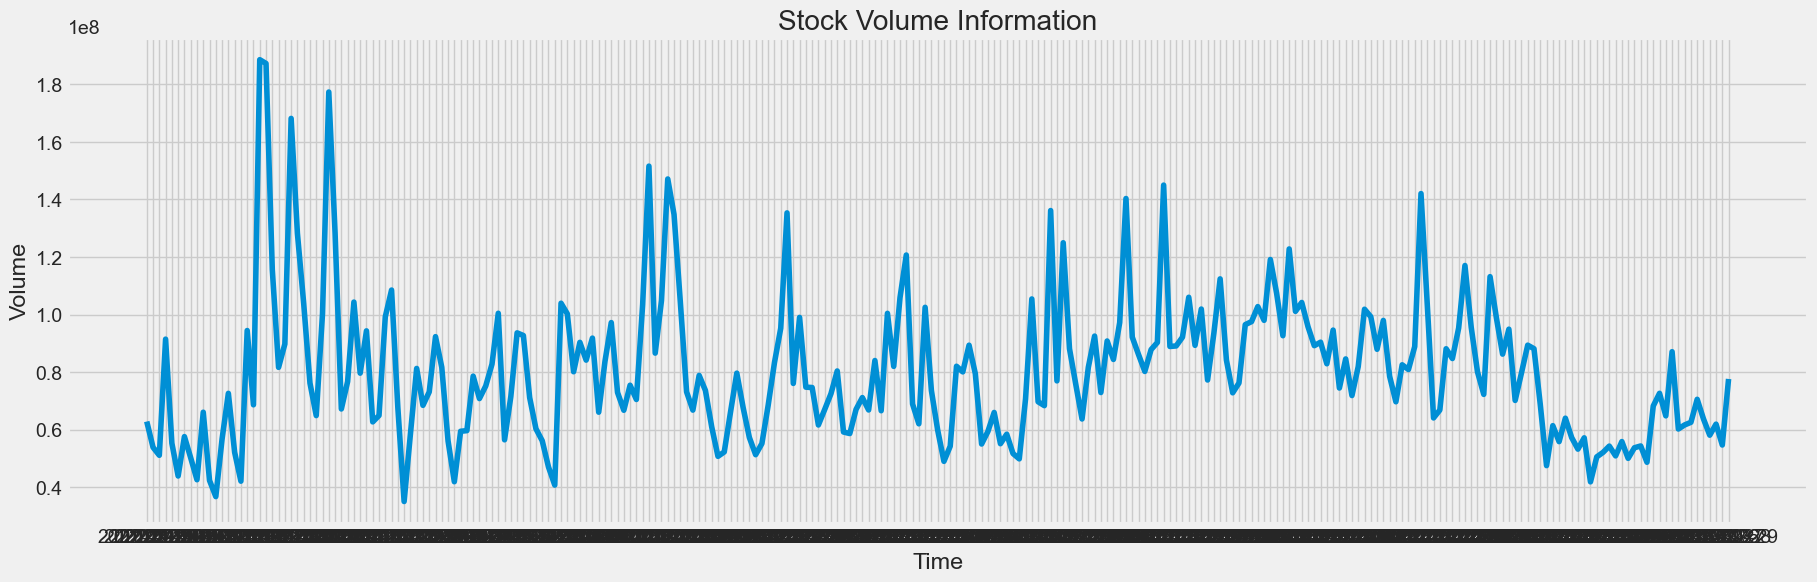

In [46]:
# Create a line plot of the volume column
plt.figure(figsize=(20,6))
plt.plot(df['Volume'])

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Volume')
plt.title('Stock Volume Information')

# Display the plot
plt.show()

<Axes: xlabel='Date'>

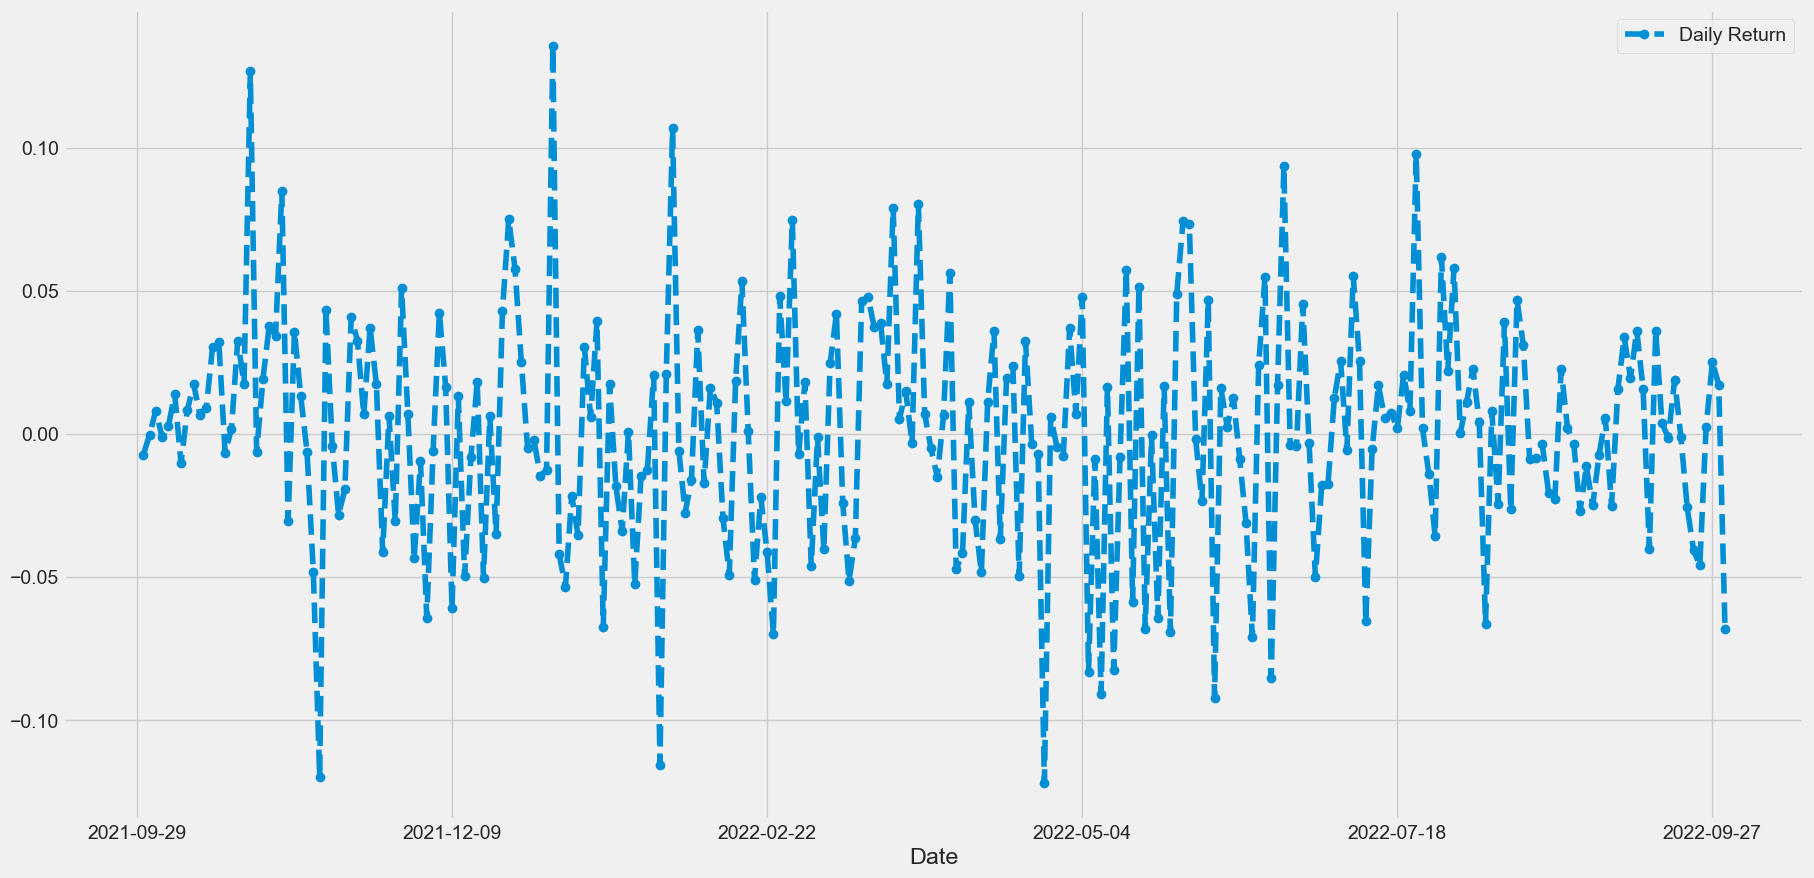

In [47]:
# We'll use pct_change to find the percent change for each day
for company in company_ticker:
    df['Daily Return'] = df['Adj Close'].pct_change()

# Then we'll plot the daily return percentage
plt.figure(figsize=(20, 10))
df['Daily Return'].plot(legend=True, linestyle='--', marker='o')



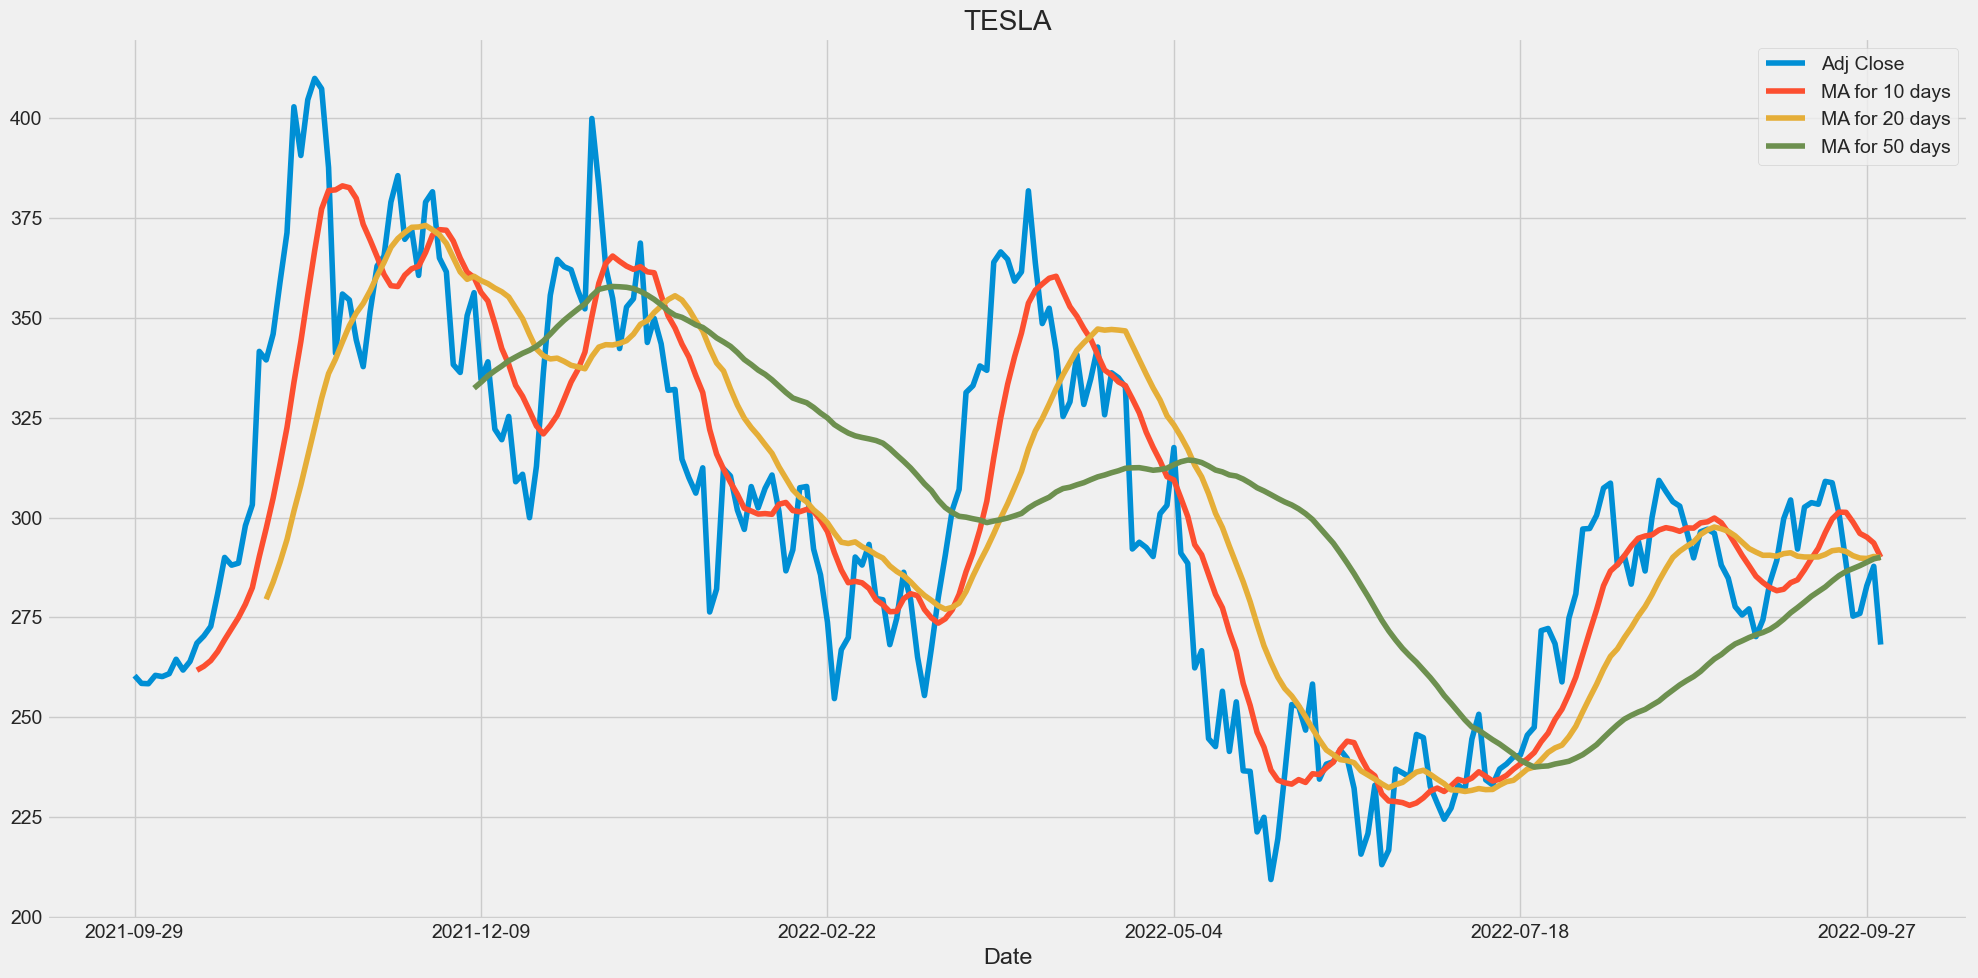

In [48]:
# Now we'll calculate and visualize the moving average
ma_day = [10, 20, 50]
for ma in ma_day:
    for company in company_ticker:
        column_name = f"MA for {ma} days"
        df[column_name] = df['Adj Close'].rolling(ma).mean()
        

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)

df[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=ax)
ax.set_title('TESLA')

fig.tight_layout()

                  Open        High         Low       Close   Adj Close   
Date                                                                     
2021-09-29  259.933319  264.500000  256.893341  260.436676  260.436676  \
2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   

                Volume company_name  positive  negative  compound   
Date                                                                
2021-09-29  62828700.0        TESLA     0.074     0.781    0.9996  \
2021-09-30  53868000.0        TESLA     0.047     0.818    0.9998   
2021-10-01  51094200.0        TESLA     0.044     0.797    0.9999   
2021-10-04  91449900.0        TESLA     0.045     0.814    0.9996   
2021-10-05  55297800.0        TESLA     0.065     0.819    0.9993  

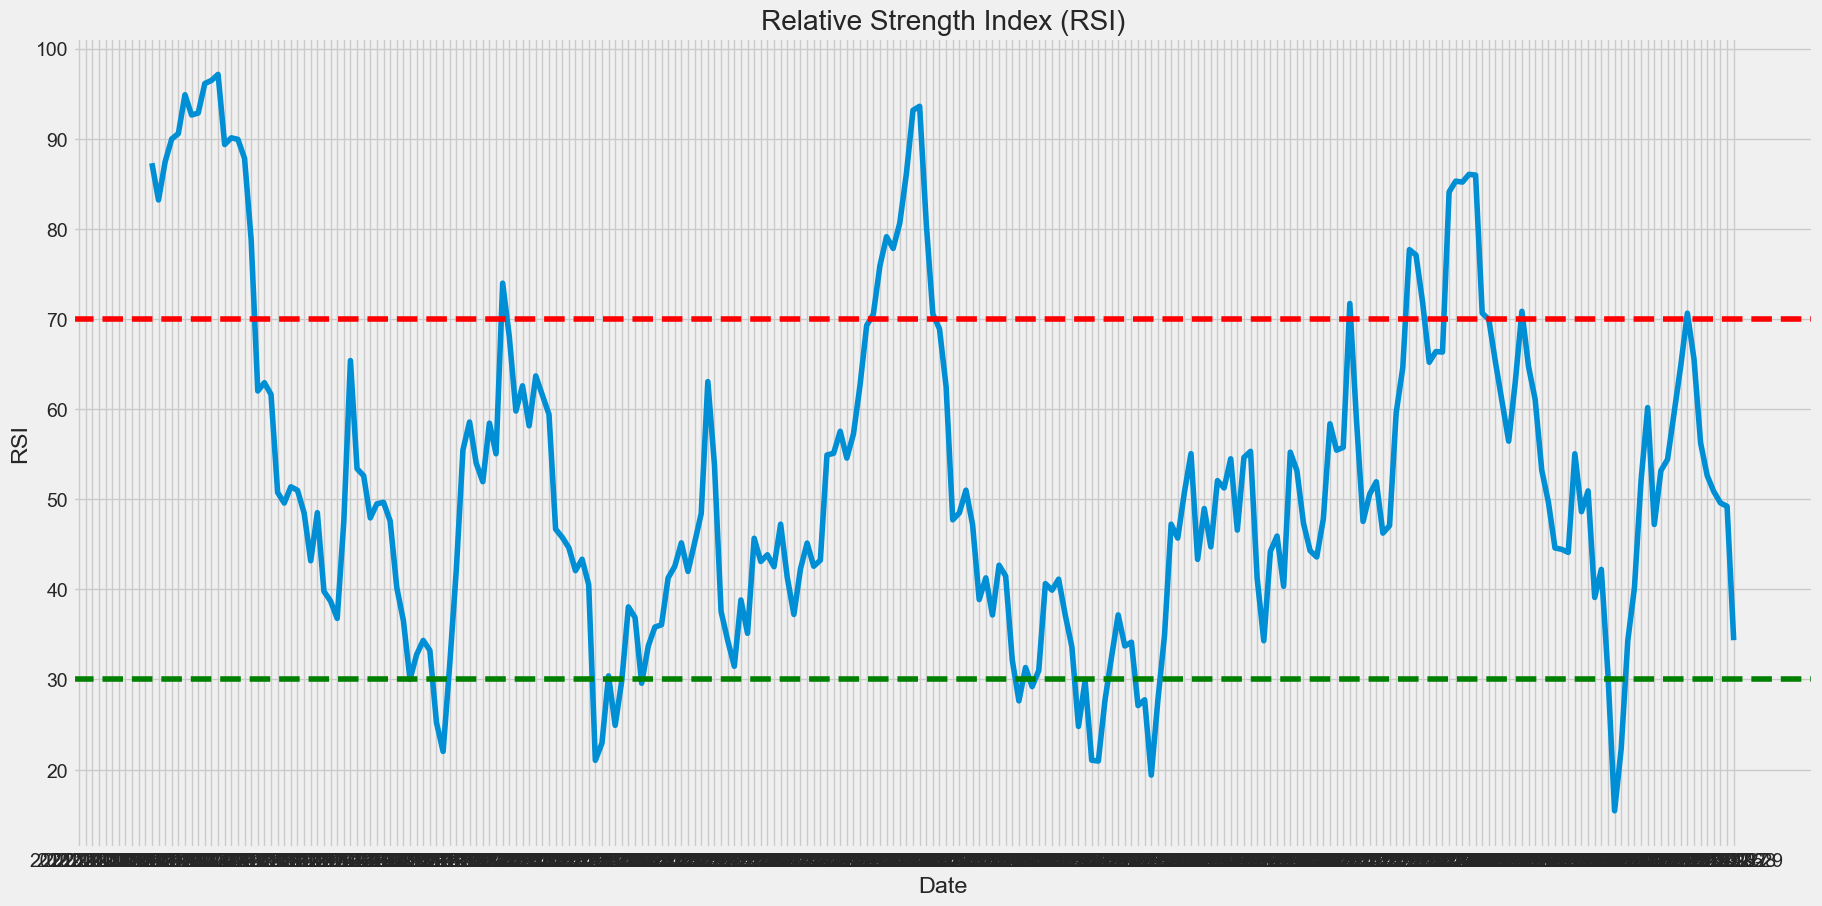

In [49]:
# Calculate and visualize the RSI (Relative Strength Index)
import pandas as pd

# Define the period for RSI calculation
rsi_period = 14

# Calculate the difference in price between each day
price_diff = df['Close'].diff()

# Get the positive gains (up) and negative gains (down)
up = price_diff.where(price_diff > 0, 0)
down = -price_diff.where(price_diff < 0, 0)

# Calculate the average gains and losses over the RSI period
avg_gain = up.rolling(window=rsi_period).mean()
avg_loss = down.rolling(window=rsi_period).mean()

# Calculate the Relative Strength (RS)
rs = avg_gain / avg_loss
rsi = 100.0 - (100.0 / (1.0 + rs))
df['RSI'] = rsi

# Print the last few rows of the DataFrame with RSI values
print(df.head())

# Plot the RSI values
plt.figure(figsize=(20, 10))
plt.plot(df['RSI'])

# Add horizontal lines at overbought and oversold levels
plt.axhline(y=70, color='r', linestyle='--')
plt.axhline(y=30, color='g', linestyle='--')

# Add axis labels and a title
plt.xlabel('Date')
plt.ylabel('RSI')
plt.title('Relative Strength Index (RSI)')

# Show the plot
plt.show()



                  Open        High         Low       Close   Adj Close   
Date                                                                     
2022-09-23  283.089996  284.500000  272.820007  275.329987  275.329987  \
2022-09-26  271.829987  284.089996  270.309998  276.010010  276.010010   
2022-09-27  283.839996  288.670013  277.510010  282.940002  282.940002   
2022-09-28  283.079987  289.000000  277.570007  287.809998  287.809998   
2022-09-29  282.760010  283.649994  265.779999  268.209991  268.209991   

                Volume company_name  positive  negative  compound   
Date                                                                
2022-09-23  63748400.0        TESLA     0.091     0.811    0.8997  \
2022-09-26  58076900.0        TESLA     0.085     0.810    0.9913   
2022-09-27  61925200.0        TESLA     0.090     0.797    0.9955   
2022-09-28  54664800.0        TESLA     0.070     0.809    0.9991   
2022-09-29  77620600.0        TESLA     0.044     0.827    0.9998  

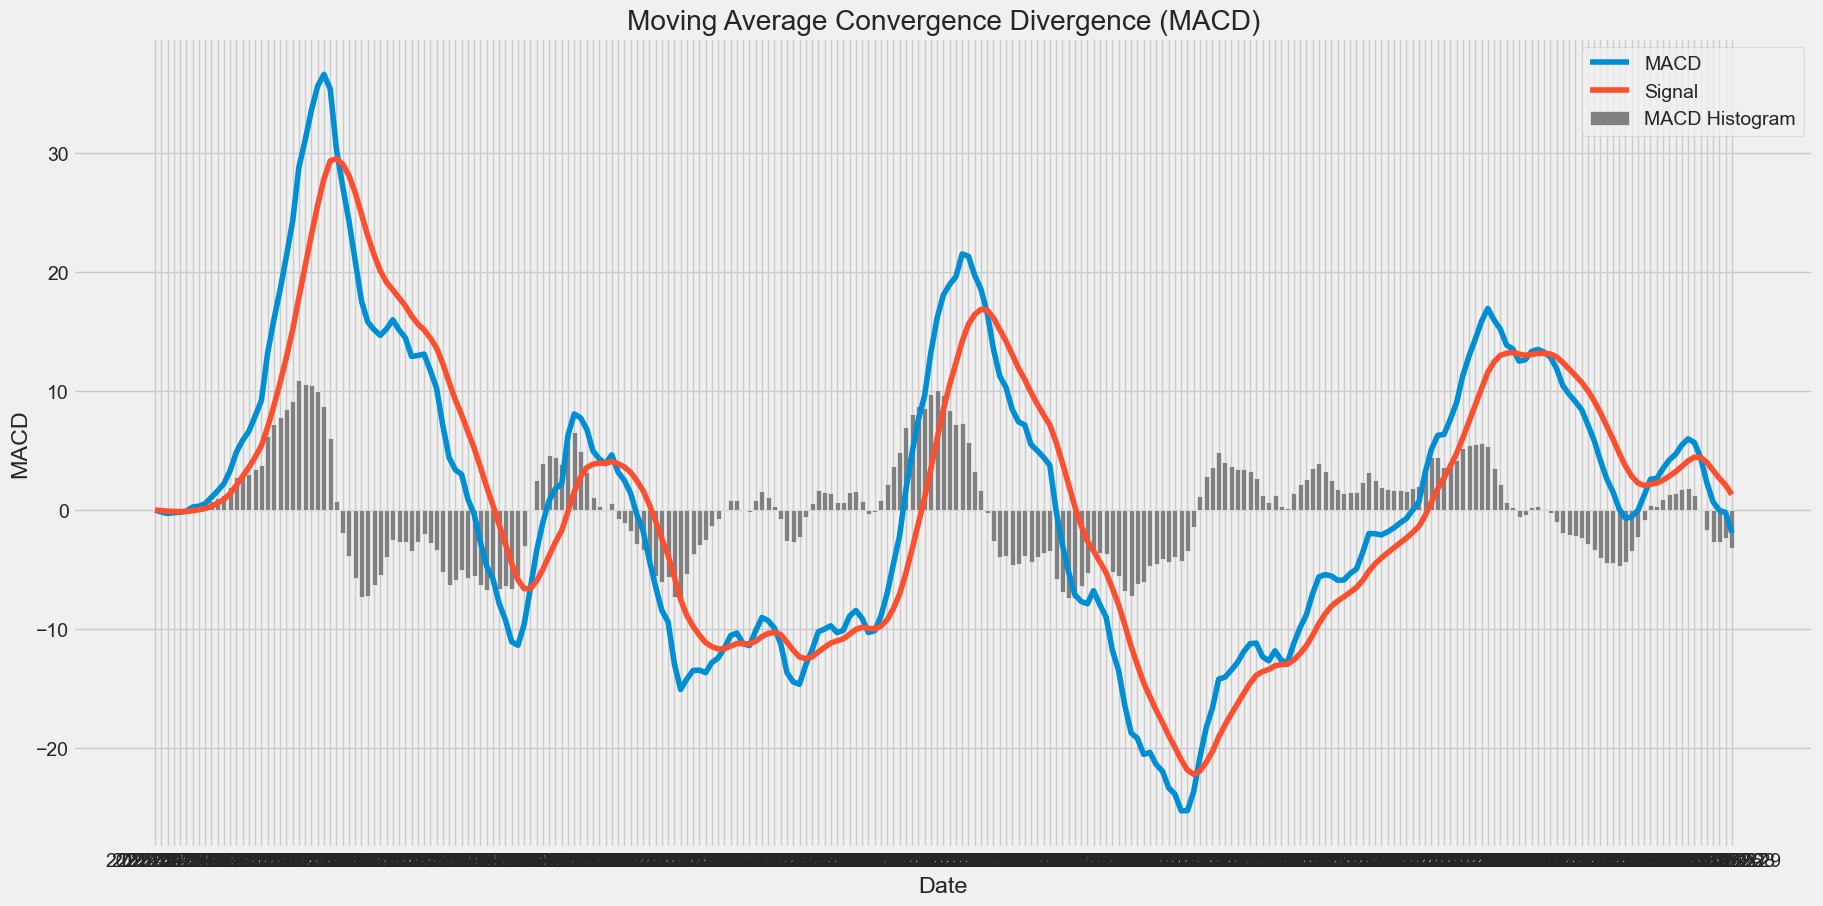

In [50]:
import pandas as pd

# Define the periods for MACD calculation
ema_period_short = 12
ema_period_long = 26
signal_period = 9

# Calculate the Exponential Moving Averages (EMA) for the short and long periods
ema_short = df['Close'].ewm(span=ema_period_short, adjust=False).mean()
ema_long = df['Close'].ewm(span=ema_period_long, adjust=False).mean()

# Calculate the MACD line by subtracting the long-term EMA from the short-term EMA
macd_line = ema_short - ema_long

# Calculate the signal line as a moving average of the MACD line over the signal period
signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()

# Calculate the MACD histogram as the difference between the MACD and signal lines
macd_histogram = macd_line - signal_line

# Add the MACD values to the DataFrame
df['MACD'] = macd_line
df['Signal'] = signal_line
df['MACD_Histogram'] = macd_histogram

# Print the last few rows of the DataFrame with MACD values
print(df.tail())


# Plot the MACD and signal line values
plt.figure(figsize=(20,10))
plt.plot(df['MACD'], label='MACD')
plt.plot(df['Signal'], label='Signal')

# Add the MACD histogram as a bar chart
plt.bar(df.index, df['MACD_Histogram'], color='gray', label='MACD Histogram')

# Add a legend and axis labels
plt.legend()
plt.xlabel('Date')
plt.ylabel('MACD')
plt.title('Moving Average Convergence Divergence (MACD)')

# Show the plot
plt.show()


In [ ]:
# Dropping unecessary columns
df = df.drop(columns='Close')
df = df.drop(columns='company_name')
df.iloc[:, :] = df.iloc[:, :].fillna(0)
df

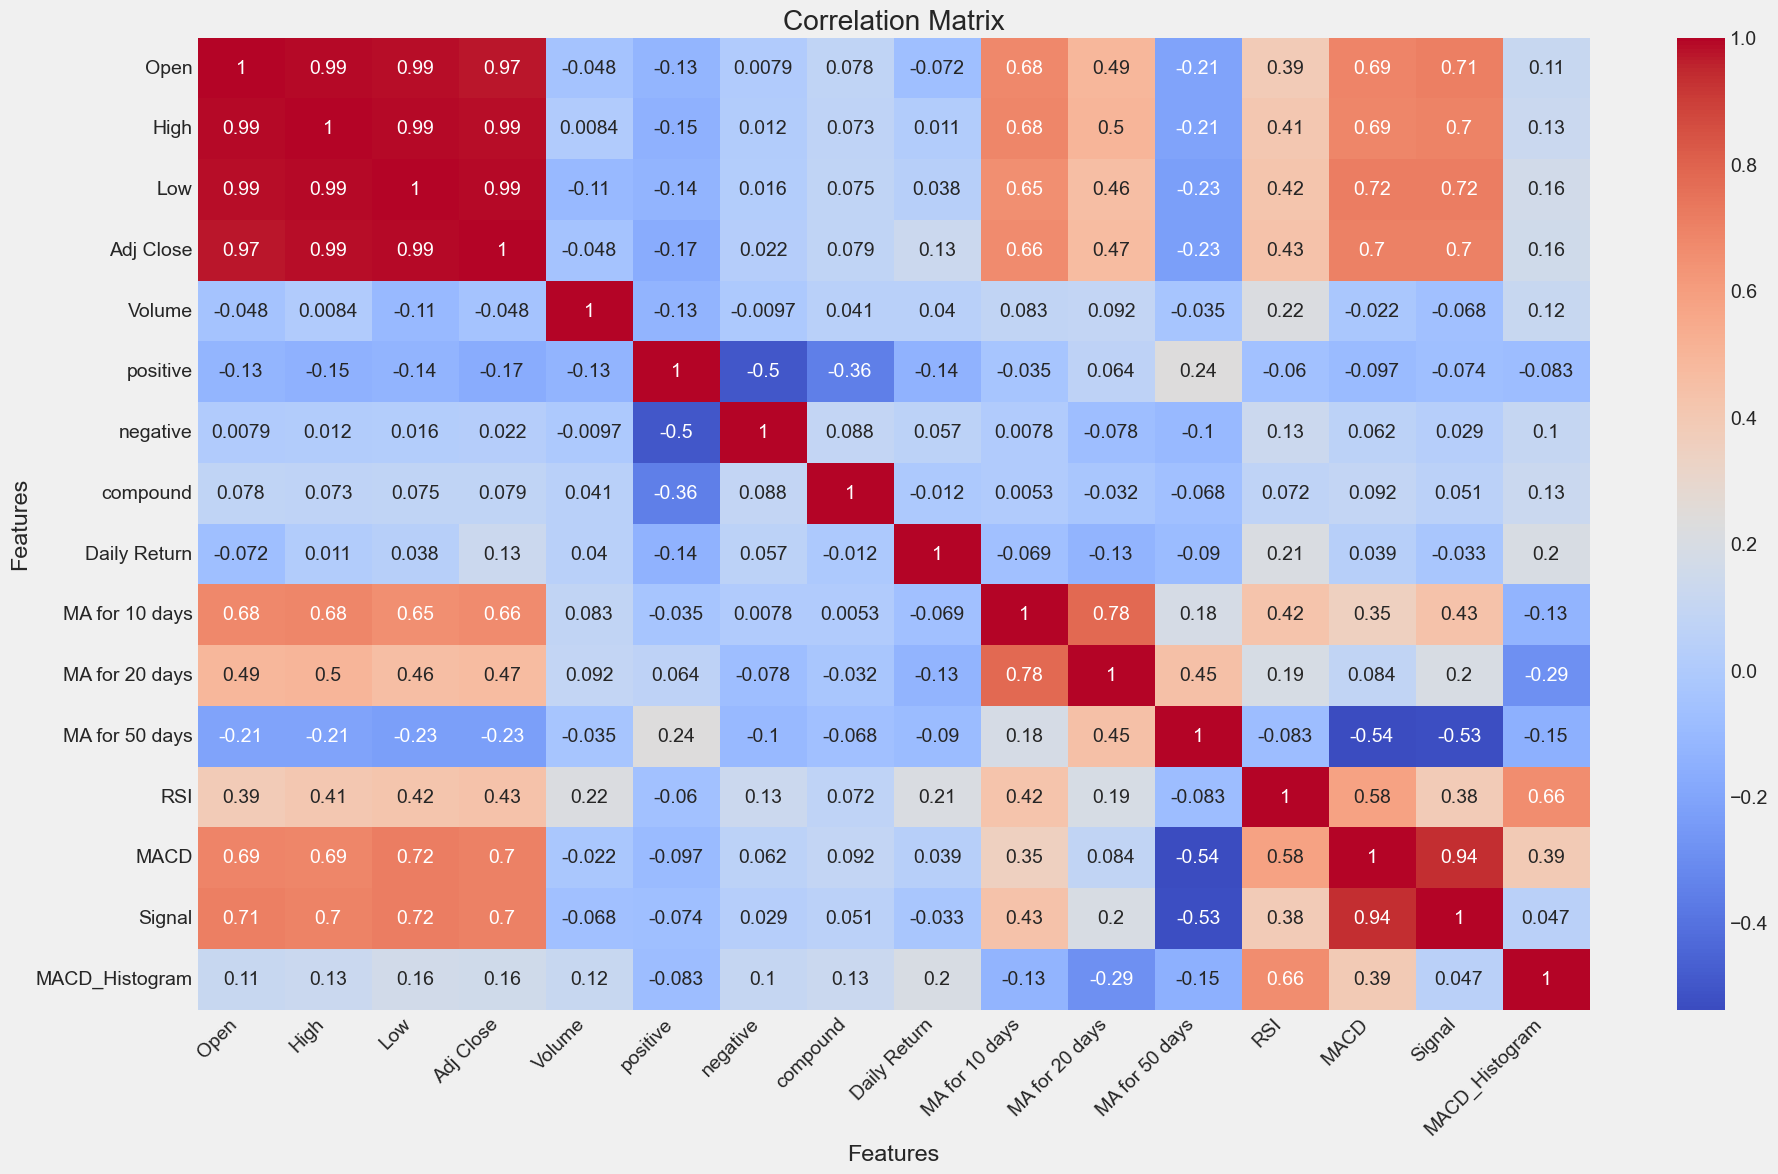

In [66]:
# CONFUSION MATRIX OF FEATURES 
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(20, 12))

# Plot the correlation matrix as a heatmap, rotating the x-axis labels by 45 degrees
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Add a title and axis labels
ax.set_title('Correlation Matrix')
ax.set_xlabel('Features')
ax.set_ylabel('Features')

# Show the plot
plt.show()

In [52]:
def create_train_test_set(df_Stock):
    
    features = df_Stock.drop(columns=['Adj Close'], axis=1)
    print(features)
    target = df_Stock['Adj Close']

    data_len = df_Stock.shape[0]
    print('Historical Stock Data length is - ', str(data_len))

    #create a chronological split for train and testing
    train_split = int(data_len * 0.6)
    print('Training Set length - ', str(train_split))

    val_split = train_split + int(data_len * 0.1)
    print('Validation Set length - ', str(int(data_len * 0.2)))

    print('Test Set length - ', str(int(data_len * 0.1)))

    # Splitting features and target into train, validation and test samples 
    X_train, X_val, X_test = features[:train_split], features[train_split:val_split], features[val_split:]
    Y_train, Y_val, Y_test = target[:train_split], target[train_split:val_split], target[val_split:]

    #print shape of samples
    print(X_train.shape, X_val.shape, X_test.shape)
    print(Y_train.shape, Y_val.shape, Y_test.shape)
    
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

In [53]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = create_train_test_set(df)

                  Open        High         Low      Volume  positive   
Date                                                                   
2021-09-29  259.933319  264.500000  256.893341  62828700.0     0.074  \
2021-09-30  260.333344  263.043335  258.333344  53868000.0     0.047   
2021-10-01  259.466675  260.260010  254.529999  51094200.0     0.044   
2021-10-04  265.500000  268.989990  258.706665  91449900.0     0.045   
2021-10-05  261.600006  265.769989  258.066681  55297800.0     0.065   
...                ...         ...         ...         ...       ...   
2022-09-23  283.089996  284.500000  272.820007  63748400.0     0.091   
2022-09-26  271.829987  284.089996  270.309998  58076900.0     0.085   
2022-09-27  283.839996  288.670013  277.510010  61925200.0     0.090   
2022-09-28  283.079987  289.000000  277.570007  54664800.0     0.070   
2022-09-29  282.760010  283.649994  265.779999  77620600.0     0.044   

            negative  compound  Daily Return  MA for 10 days  M

In [54]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, Y_train)
print('LR Coefficients: \n', lr.coef_)
print('LR Intercept: \n', lr.intercept_)

LR Coefficients: 
 [-1.26130548e-01  4.78661526e-01  5.53692433e-01 -8.11772394e-09
 -6.29986916e+01  6.07529680e+00  2.81283202e+00  1.27619679e+02
  8.72962612e-03  1.84597283e-02  1.77547030e-03 -1.74428360e-02
  1.48041967e-01  4.52423026e-02  1.02799664e-01]
LR Intercept: 
 19.424423095208397


### Evaluation

In [55]:
print("Performance (R^2): ", lr.score(X_train, Y_train))

Performance (R^2):  0.9923695535571795


In [56]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [57]:
Y_train_pred = lr.predict(X_train)
Y_val_pred = lr.predict(X_val)
Y_test_pred = lr.predict(X_test)

print("Training R-squared: ",round(metrics.r2_score(Y_train,Y_train_pred),2))
print("Training Explained Variation: ",round(metrics.explained_variance_score(Y_train,Y_train_pred),2))
print('Training MAPE:', round(get_mape(Y_train,Y_train_pred), 2)) 
print('Training Mean Squared Error:', round(metrics.mean_squared_error(Y_train,Y_train_pred), 2)) 
print("Training RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_train,Y_train_pred)),2))
print("Training MAE: ",round(metrics.mean_absolute_error(Y_train,Y_train_pred),2))

print(' ')

print("Validation R-squared: ",round(metrics.r2_score(Y_val,Y_val_pred),2))
print("Validation Explained Variation: ",round(metrics.explained_variance_score(Y_val,Y_val_pred),2))
print('Validation MAPE:', round(get_mape(Y_val,Y_val_pred), 2)) 
print('Validation Mean Squared Error:', round(metrics.mean_squared_error(Y_train,Y_train_pred), 2)) 
print("Validation RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_val,Y_val_pred)),2))
print("Validation MAE: ",round(metrics.mean_absolute_error(Y_val,Y_val_pred),2))

print(' ')

print("Test R-squared: ",round(metrics.r2_score(Y_test,Y_test_pred),2))
print("Test Explained Variation: ",round(metrics.explained_variance_score(Y_test,Y_test_pred),2))
print('Test MAPE:', round(get_mape(Y_test,Y_test_pred), 2)) 
print('Test Mean Squared Error:', round(metrics.mean_squared_error(Y_test,Y_test_pred), 2)) 
print("Test RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_test,Y_test_pred)),2))
print("Test MAE: ",round(metrics.mean_absolute_error(Y_test,Y_test_pred),2))

Training R-squared:  0.99
Training Explained Variation:  0.99
Training MAPE: 0.79
Training Mean Squared Error: 11.52
Training RMSE:  3.39
Training MAE:  2.56
 
Validation R-squared:  0.94
Validation Explained Variation:  0.95
Validation MAPE: 1.49
Validation Mean Squared Error: 11.52
Validation RMSE:  4.59
Validation MAE:  3.63
 
Test R-squared:  0.97
Test Explained Variation:  0.99
Test MAPE: 1.59
Test Mean Squared Error: 25.55
Test RMSE:  5.05
Test MAE:  4.18


In [58]:
df_pred = pd.DataFrame(Y_val.values, columns=['Actual'], index=Y_val.index)
df_pred['Predicted'] = Y_val_pred
df_pred = df_pred.reset_index()
df_pred.loc[:, 'Date'] = pd.to_datetime(df_pred['Date'],format='%Y-%m-%d')

### Plot Predicted vs Actual Prices on Time Series plot

<Figure size 2000x1000 with 0 Axes>

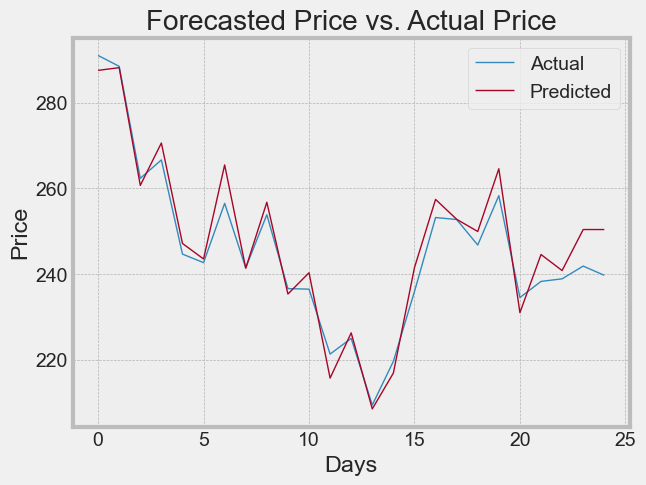

In [61]:
# Set the size of the figure


# Plot your data
plt.figure(figsize=(20,10))
df_pred[['Actual', 'Predicted']].plot(linewidth=1.0)

# Set the x-axis and y-axis labels
plt.xlabel('Days')
plt.ylabel('Price')

# Add a title to the plot
plt.title('Forecasted Price vs. Actual Price')
plt.grid(True)
# Show the plot
plt.show()

Overall the Predictions looks good for the test data! 